In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from CallOption import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 512 # number of trajectories (batch size)
N = 200  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4
lr = 1e-3

In [4]:
n_iter = 21 * 10 ** 2
lr = 1e-5

In [6]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 3.960e-01, Y0: -0.733, Time: 28.85, Learning Rate: 1.000e-03
It: 100, Loss: 1.382e-01, Y0: 0.164, Time: 1.23, Learning Rate: 1.000e-03
It: 200, Loss: 1.212e-02, Y0: 0.201, Time: 1.22, Learning Rate: 1.000e-03
It: 300, Loss: 1.104e-01, Y0: 0.204, Time: 1.20, Learning Rate: 1.000e-03
It: 400, Loss: 6.750e-02, Y0: 0.217, Time: 1.23, Learning Rate: 1.000e-03
It: 500, Loss: 1.328e-01, Y0: 0.199, Time: 1.23, Learning Rate: 1.000e-03
It: 600, Loss: 1.901e-03, Y0: 0.191, Time: 1.21, Learning Rate: 1.000e-03
It: 700, Loss: 9.754e-02, Y0: 0.197, Time: 1.24, Learning Rate: 1.000e-03
It: 800, Loss: 7.434e-02, Y0: 0.185, Time: 1.25, Learning Rate: 1.000e-03
It: 900, Loss: 1.814e-02, Y0: 0.130, Time: 1.22, Learning Rate: 1.000e-03
It: 1000, Loss: 1.910e-02, Y0: 0.279, Time: 1.23, Learning Rate: 1.000e-03
It: 1100, Loss: 5.492e-02, Y0: 0.276, Time: 1.26, Learning Rate: 1.000e-03
It: 1200, Loss: 2.253e-02, Y0: 0.142, Time: 1.27, Learning Rate: 1.000e-03
It: 1300, Loss: 9.637e-03, Y

In [33]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 22900, Loss: 1.027e-02, Y0: 0.180, Time: 0.15, Learning Rate: 1.000e-06
It: 23000, Loss: 1.226e-03, Y0: 0.180, Time: 15.77, Learning Rate: 1.000e-06
It: 23100, Loss: 2.332e-04, Y0: 0.180, Time: 15.50, Learning Rate: 1.000e-06
It: 23200, Loss: 3.123e-04, Y0: 0.181, Time: 15.60, Learning Rate: 1.000e-06
It: 23300, Loss: 2.240e-04, Y0: 0.180, Time: 16.10, Learning Rate: 1.000e-06
It: 23400, Loss: 2.292e-01, Y0: 0.180, Time: 15.65, Learning Rate: 1.000e-06
It: 23500, Loss: 2.494e-04, Y0: 0.180, Time: 15.69, Learning Rate: 1.000e-06
It: 23600, Loss: 5.998e-04, Y0: 0.180, Time: 15.95, Learning Rate: 1.000e-06
It: 23700, Loss: 2.527e-01, Y0: 0.180, Time: 15.64, Learning Rate: 1.000e-06
It: 23800, Loss: 1.707e-04, Y0: 0.180, Time: 15.72, Learning Rate: 1.000e-06
It: 23900, Loss: 4.993e-04, Y0: 0.180, Time: 15.83, Learning Rate: 1.000e-06
It: 24000, Loss: 1.506e-03, Y0: 0.180, Time: 15.66, Learning Rate: 1.000e-06
It: 24100, Loss: 1.961e-02, Y0: 0.180, Time: 15.78, Learning Rate: 1.0

In [5]:
model.load_model("models/CallOption4-256.pth")

In [6]:
np.random.seed(0)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(15):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

In [7]:
X_pred = X_pred[:500,:]

In [8]:
from scipy.stats import multivariate_normal as normal

In [9]:
X_preds = X_pred[:,:,0]

In [10]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    return call_price

def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0: 
                option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0) 
    
    return option_prices


# Given parameters
K = 1.0     # Strike price
r = 0.05   # Risk-free interest rate
sigma = 0.4  # Volatility
q = 0      # Dividend yield (assuming none)
T = 1      # Expiry time in years

Y_test = calculate_option_prices(X_preds, t_test[0], K, r, sigma, T, q)

/tmp/ipykernel_1924113/1740677467.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


In [11]:
errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

(5.697459058995195e-05, 0.0002584482961946937)

In [12]:
np.sqrt(errors.mean())

0.00754815146840284

In [13]:
graph = model.iteration, model.training_loss

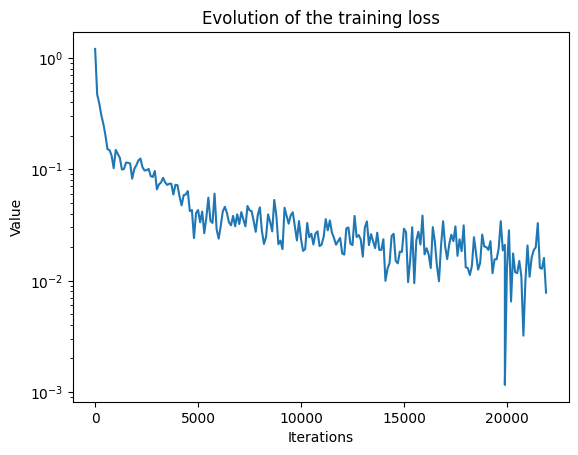

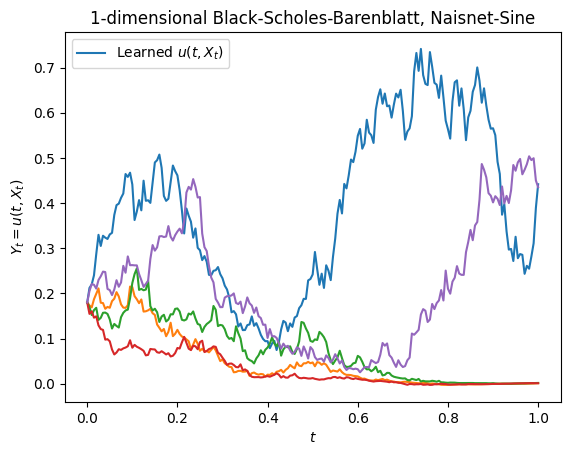

In [14]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 5
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

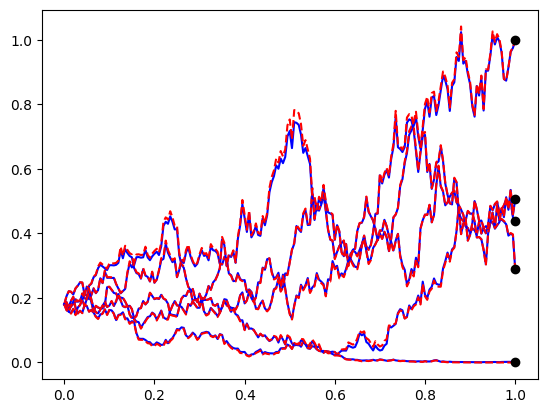

In [15]:
for i in range(4, 100, 20):
    plt.plot(t_test[i], Y_pred[i], 'b', label='Learned $u(t,X_t)$')
    plt.plot(t_test[i], Y_test[i], 'r--', label='Exact $u(t,X_t)$')
    plt.plot(t_test[i, -1], Y_test[i, -1], 'ko', label='$Y_T = u(T,X_T)$')

In [16]:
Y_pred.shape

(8192, 201, 1)

In [17]:
r = 0.05

In [18]:
Y_preds = Y_pred.reshape(8192,201)

In [19]:
time_stamps = t_test[0].reshape(201,)
time_stamps

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [20]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0) * 100  
epe

array([18.004526, 18.017048, 18.015959, 18.03676 , 18.021004, 18.013712,
       18.013283, 17.996473, 17.997501, 17.980257, 17.96793 , 17.993309,
       18.00399 , 17.991982, 17.997295, 17.979225, 17.959507, 17.986614,
       17.976324, 17.957554, 17.980537, 17.925552, 17.955866, 17.933   ,
       17.926672, 17.93366 , 17.891718, 17.870499, 17.910515, 17.897549,
       17.90308 , 17.913742, 17.905788, 17.897636, 17.89577 , 17.890203,
       17.927591, 17.932602, 17.928951, 17.945906, 17.964441, 17.982609,
       18.002554, 18.01486 , 18.000679, 17.99141 , 17.984367, 17.982088,
       17.960033, 17.990492, 18.018822, 18.002443, 18.028805, 18.029518,
       18.03331 , 18.030754, 18.05722 , 18.05519 , 18.016865, 18.050016,
       18.045845, 18.060823, 18.069414, 18.073301, 18.071514, 18.077488,
       18.045263, 18.038673, 18.04308 , 18.07913 , 18.120747, 18.081667,
       18.069227, 18.05106 , 18.057814, 18.06442 , 18.04366 , 18.0275  ,
       18.038801, 18.022284, 18.056805, 18.06694 , 

In [21]:
ene = np.mean(np.minimum(Y_preds,0),axis=0) * 100
ene

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.52850293e-05,
       -5.99829036e-05, -9.53746203e-05, -3.24185748e-05, -2.79676897e-05,
       -6.35881443e-05, -

In [22]:
s=100.0 # spot price
k=100.0 # strike price
r=0.05 # risk-free rate
sigma=0.4 # volatility
T=1 # time to maturity

d1 = (np.log(s/k) + (r + 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))
d2 = (np.log(s/k) + (r - 0.5 * sigma ** 2) * (T - 0) ) / (sigma * np.sqrt(T - 0))

call = (s * normal.cdf(d1, 0.0, 1.0) - k * np.exp(-r * (T - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [23]:
call

18.022951450216674

In [24]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

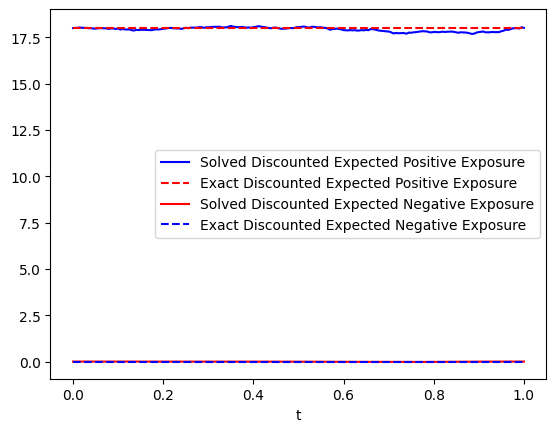

In [25]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [26]:
model.save_model("models/CallOption4-256.pth")